## Get maps ifr_stackatLever for all the cells and save them 


+ We get the stacked and save them here using a summary of this jupyter notebook : http://localhost:8888/lab/tree/repo/autopi_inter/lever_press/TrialMatrix_leverPress_Pascal_8.ipynb
+ we get the maps and spike_time cross corelations using some part of the code in this : http://localhost:8888/lab/tree/repo/autopi_inter/Cross_correlation/Get_crossCorr_RF.ipynb



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run ../setup_project.py
%run ../neuronAutopi.py

%run ../generic_plot_functions.py
import os.path
from spikeA.Dat_file_reader import Dat_file_reader
from scipy.signal import welch
from scipy.ndimage import gaussian_filter1d
import numpy as np
from scipy.signal import find_peaks, peak_widths, peak_prominences
from scipy import integrate
from scipy.ndimage import gaussian_filter1d 
import os
from itertools import product
from scipy.stats import pearsonr
from scipy import signal

projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_inter",
                                                                dataPath="/adata/projects/autopi_inter/",dlcModelPath="/adata/models")


creating myProject, an autopipy.project object
Project name: autopi_inter
dataPath: /adata/projects/autopi_inter/
dlcModelPath: /adata/models
Reading /adata/projects/autopi_inter//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [11]:
prepareSessionsForSpatialAnalysisProject(sSessions[:16],myProject.sessionList[:16]) ### sSeslist >>>> sSessions

Loading Animal_pose and Spike_train, sSes.ap and sSes.cg
Will load .pose.npy


100%|███████████████████████████████████████████| 16/16 [00:08<00:00,  1.89it/s]

Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [12]:
for ses, sSes in tqdm(zip(myProject.sessionList[:16],sSessions[:16])):
    getSearchHomingIntervals(ses,sSes)

16it [00:00, 40.65it/s]


In [13]:
%%time
fn=myProject.dataPath+"/results/cells_with_leverCells.csv"
print('loading', fn)
cells = pd.read_csv(fn)

## load the levertime press 
fn ='behavior_180_v2.csv'
print('loading', fn)
res = pd.read_csv(fn)

LeverPressinRestime= res[res.sessionName== sSes.name].levertimeRes.values
LeverPressinRestime.shape, len(ses.trials)


loading /adata/projects/autopi_inter//results/cells_with_leverCells.csv
loading behavior_180_v2.csv
CPU times: user 109 ms, sys: 42 µs, total: 109 ms
Wall time: 108 ms


((121,), 121)

In [14]:
def samples2time(l):
    return bin_size_sec*(np.arange(l)-l/2+.5)

def get_sSesId_nId(cellId):
    
    sesName= cellId.split('_')[0]
    cellName= cellId.split('_')[1]
    sesid= [sSes.name for sSes in sSessions].index(sesName)
    sSes= sSessions[sesid]
    ses= myProject.sessionList[sesid]
    nid= [n.name for n in sSes.cg.neuron_list].index(cellName)
    n= sSes.cg.neuron_list[nid]
    return sSes,ses,n, nid 

def get_stacked_ifr_all_cropped(sSes,ses):
    session_trials = res[(res.sessionName == sSes.name) & (res.valid==True)].sort_values(by='trialNo')
    LeverPressinRestime = session_trials.levertimeRes.values
    
    atLever_times = np.concatenate([ses.intervalDict['atLever_light'], ses.intervalDict['atLever_dark']])
    
    
    
    trial_lever_times = []
    # loop through trials in the same order as trial dataframe "session_trials"
    for i,LeverPress in enumerate(LeverPressinRestime):
        # find atLever time interval for given trial
        found = False
        for (start,end) in atLever_times:
            if start <= LeverPress <= end:
                found = True
                break
        if not found:
            # raise IOError("not found")
            continue
        if found:
            #print("trial",i,"LeverPress",LeverPress,"occurs within",start,end) # keep the index of trial so we can reference in case one is not found
            trial_lever_times.append({'trial_id': i, 'start': start, 'end': end, 'LeverPress': LeverPress})
            
            
            
    atLeverIFR_trials = [] # number of trials * number of cells * time

    for t in trial_lever_times:
        start,end = t['start'],t['end']

        # IFR around lever for each trial
        atLeverifr = [] # number of cells * time

        for n in sSes.cg.neuron_list:
            n.spike_train.set_intervals(np.array([start,end]))
            n.spike_train.instantaneous_firing_rate(bin_size_sec=bin_size_sec, sigma=sigma, time_start=start, time_end=end, outside_interval_solution="remove")
            n.spike_train.ifr[0][n.spike_train.ifr[0] > 80] = 0
            atLeverifr.append(n.spike_train.ifr[0])
        atLeverifr = np.array(atLeverifr) # number of cells * trial duration
        atLeverIFR_trials.append(atLeverifr)
        
        
    # get time before and after leverpress for aligned stack
    dt=[]
    for t in trial_lever_times:
        start,end,leverpress = t['start'],t['end'],t['LeverPress']
        dt.append(max(leverpress-start, end-leverpress))
    maxtime = np.max(dt)
    
    time_samples = int(np.ceil(maxtime/bin_size_sec)) # before and after lever press


    # stack : trials * time * cells
    # time aligning is by trial

    ncells = len(sSes.cg.neuron_list)
    ntrials = len(trial_lever_times)
    stackedifr_cells = np.zeros((ntrials, ncells, time_samples*2))
    stackedifr_cells[:] = np.nan # pad empty space with nan

    for i, (atLeverifr, t) in enumerate(zip(atLeverIFR_trials, trial_lever_times)):
        # print('trial',i,t,'/',"IFR shape:",atLeverifr.shape)
        # align trials
        start,end,leverpress = t['start'],t['end'],t['LeverPress']
        left_pad_samples = time_samples - int(np.ceil((leverpress-start)/bin_size_sec)) # how many nans to add before start (for this trial, all cells), so that lever press is centered
        stackedifr_cells[i,:,left_pad_samples:left_pad_samples+atLeverifr.shape[1]] = atLeverifr

    trial_ids = np.array([t['trial_id'] for t in trial_lever_times])
    # mask for light or dark
    trial_light = (session_trials.light == 'light').values
    trial_light_onids = trial_light[trial_ids]

    trials_light_ids = np.where(trial_light_onids)[0]
    trials_dark_ids = np.where(~trial_light_onids)[0]
    
    ###############
    #### Crop the stack 0.5 second before and after the leverPress to remove Nans 
    ##############
    time = samples2time(time_samples*2)

    # crop
    samples_to_keep = 50 #100
    indx0,indx1 = len(time)//2-samples_to_keep//2, len(time)//2+samples_to_keep//2
    time_scaled = time[indx0:indx1]
    stackedifr_cells = stackedifr_cells[:,:,indx0:indx1]
    #time, stackedifr_cells.shape

    #return stackedifr_cells, trials_light_ids, trials_dark_ids, time, time_scaled 
    return stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled 

def clean_stack(stack):
        return stack[~np.isnan(stack).any(axis=1)]
    
def plot_stackedifr_oneCell(gs, stackedifr_cells, cindx, trials_light_ids, trials_dark_ids, legend=True, bbox_to_anchor=(1.35, 1), nonan=True):
        
    # For light trials
    ax = fig.add_subplot(gs[0])
    stackedifr_light = stackedifr_cells[trials_light_ids, cindx, :]
    if nonan:
        stackedifr_light = clean_stack(stackedifr_light)
        cat = ax.pcolor(stackedifr_light)
        ax.set_title(f"nid:{cindx} -{'light'}\n{'remove Nans'}", fontsize=9)
    else: 
        cat = ax.pcolor(stackedifr_light)
        ax.set_title(f"nid:{cindx} -{'light'}", fontsize=9)
    
    # Modify the x-axis
    xticks_positions = [0, stackedifr_light.shape[1] // 2, stackedifr_light.shape[1] - 1]
    ax.set_xticks(xticks_positions)
    ax.set_xticklabels([-0.5, 0, 0.5])
    ax.set_xlabel("time relative \n to lever press [s]")
    ax.set_ylabel("Trials")

    # Add red vertical dashed line at 0
    ax.axvline(xticks_positions[1], color='red', linestyle='--', label="at lever press")
    fig.colorbar(cat, ax=ax)

    # For dark trials
    ax = fig.add_subplot(gs[1])
    stackedifr_dark = stackedifr_cells[trials_dark_ids, cindx, :]
    if nonan:
        stackedifr_dark = clean_stack(stackedifr_dark)
        cat = ax.pcolor(stackedifr_dark)
        ax.set_title(f"nid:{cindx} -{'dark'}\n{'remove Nans'}", fontsize=9)
    else: 
        cat = ax.pcolor(stackedifr_dark)
        ax.set_title(f"nid:{cindx} -{'dark'}", fontsize=9)
    
    xticks_positions = [0, stackedifr_dark.shape[1] // 2, stackedifr_dark.shape[1] - 1]
    ax.set_xticks(xticks_positions)
    ax.set_xticklabels([-0.5, 0, 0.5])
    ax.set_xlabel("time relative \n to lever press [s]")
    ax.set_ylabel("Trials")

    # Add red vertical dashed line at 0
    ax.axvline(xticks_positions[1], color='red', linestyle='--', label="leverPress")
    fig.colorbar(cat, ax=ax)
    
    if legend:
        ax.legend(loc='upper center', bbox_to_anchor=bbox_to_anchor)

Now get the expected values

In [15]:
def expected_value(v, w):
    indxs = np.isfinite(v) & np.isfinite(w)  # Ensure both v and w are finite
    if np.sum(w[indxs]) == 0:  # Check if weights sum to zero
        return np.nan  # Return NaN or some default value to indicate the issue
    return np.average(v[indxs], weights=w[indxs])  # Proceed if weights are valid

def plot_expected_value(ax, stackedifr_cells,trials_light_ids,cindx,time_scaled, light= 'light',  bbox_to_anchor= (1.45,1), legend= False):
    
    #ax= fig.add_subplot(gs[0])
    ifrstack= stackedifr_cells[trials_light_ids,cindx,:]
    s0 = np.nanmean(ifrstack, axis=(0)) # axis: trials * 1 neuron
    t_mean = expected_value(time_scaled,s0) ## averaged expected_value 
    print(t_mean)
    l = ax.plot(time_scaled,s0)
    ax.axvline(t_mean, c='green', lw=1.5, label="Expval")
    ax.axvline(0,linestyle='--', c='red', lw=1.0, label="leverPress")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("relative time to \n lever press [s]")
    ax.set_ylabel("sum of firing rate [Hz] \n  of all trials")
    ax.set_title(f"{light} \n exp_val:{t_mean:.3f} " , fontsize= 9)
    if legend: 
        ax.legend(loc='center', bbox_to_anchor=bbox_to_anchor)

def plot_expValues_oneCell(gs, stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled,bbox_to_anchor= (1.45,1),  legend= False):

    for i, (l,light_inx) in enumerate(zip(['light', 'dark'], [trials_light_ids, trials_dark_ids])):
        ax= fig.add_subplot(gs[i])
        plot_expected_value(ax, stackedifr_cells,light_inx,cindx,time_scaled, light= l,bbox_to_anchor= bbox_to_anchor, legend= legend)

In [16]:
bin_size_sec = 0.02
sigma=1

ses= myProject.sessionList[15]
sSes= sSessions[15]

In [17]:
stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled = get_stacked_ifr_all_cropped(sSes,ses)

0.019180505404830524
0.022968904402051977


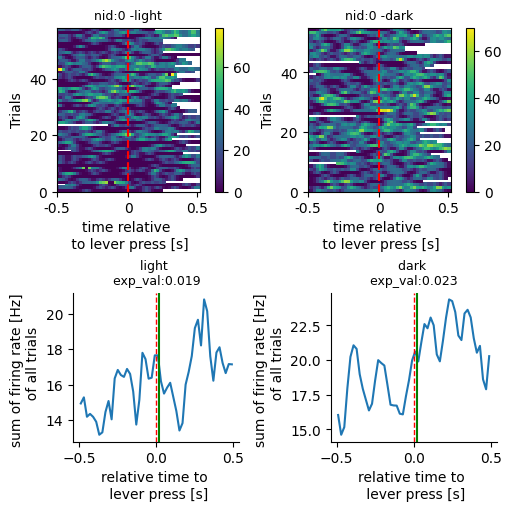

In [18]:
col=4
row=2
sizePerRow, sizePerCol = 2.5,2.5
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(row,col, figure=fig, wspace= 0.8) # all our figure

cindx= 0

gs0= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0,:2])#, width_ratios=[1.5,2,1,1])
plot_stackedifr_oneCell(gs0, stackedifr_cells,cindx,trials_light_ids,trials_dark_ids, legend= False, bbox_to_anchor= (1.45,1), nonan=False)

gs1= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1,:2])#, width_ratios=[1.5,2,1,1])
plot_expValues_oneCell(gs1, stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled,bbox_to_anchor= (1.45,1),  legend= False)


## Run the function for all sessions 

In [ ]:
get_stacked_ifr_all_sessions = [get_stacked_ifr_all_cropped(sSes,ses) for sSes,ses in tqdm(zip(sSessions,myProject.sessionList))]

In [40]:
len(get_stacked_ifr_all_sessions), type(get_stacked_ifr_all_sessions[0]), get_stacked_ifr_all_sessions[0][0].shape, len(get_stacked_ifr_all_sessions[0])

(180, tuple, (85, 25, 50), 4)

In [28]:
fn

'/adata/projects/autopi_inter/results/leverPress/stacked_ifr_all_sessions.pkl'

In [30]:
## save the ifr_stack for all the sessions so I dont have to run this again 
fn= myProject.dataPath+ 'results/leverPress/stacked_ifr_all_sessions.pkl'
# Save to a file
with open(fn, 'wb') as f:
    print('saving: ')
    pickle.dump(get_stacked_ifr_all_sessions, f)

In [20]:
# To load the list back from the file
fn= myProject.dataPath+ 'results/leverPress/stacked_ifr_all_sessions.pkl'

with open(fn, 'rb') as f:
    stacked_ifr_all_sessions = pickle.load(f)

In [29]:
len(stacked_ifr_all_sessions), len(stacked_ifr_all_sessions[0])

(180, 4)

Calculate the Expval for all the fs and gc for each session 

+ then we wanna select the cells that have the expval around zero 
+ then we wanna plot their map and see in the lever_map do they have 

In [72]:
def get_expval_fsandgc( sSes, stack):

    results_dict = {'fs': [], 'gc': []}
    stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled = stack[0], stack[1], stack[2], stack[3]

    session_cells = cells[(cells.session == sSes.name)]
    gc_indx = session_cells.gridCell_FIRST.values
    fsin_indx = ((session_cells.interneuron) & (session_cells.mrate_RF1 > 10)).values

    fs_cluIds = list(session_cells[(session_cells.interneuron) & (session_cells.mrate_RF1> 10)].cluId)
    gc_cluIds= list(session_cells[(session_cells.gridCell_FIRST) & (~session_cells.cluId.isin(fs_cluIds))].cluId)

    light_conditions = [trials_light_ids, trials_dark_ids]
    light_conditions_str = ['light', 'dark']
    neuron_fr_max = np.nanmax(stackedifr_cells, axis=(0, 2))

    with np.errstate(invalid='ignore'):
        stackedifr_cells_normalized = (stackedifr_cells.transpose((0, 2, 1)) / neuron_fr_max).transpose(0, 2, 1)

    for light_condition, light_condition_str in zip(light_conditions, light_conditions_str):
        if fsin_indx is not None and len(fsin_indx) > 0:
        #if len(fsin_indx) > 0:
                #print(len(fsin_indx))
                for fs, fs_cluId in zip (np.where(fsin_indx)[0], fs_cluIds):
                    #print(fs,fs_cluId)
                    ifrstack= stackedifr_cells[light_condition,fs,:]
                    s0 = np.nanmean(ifrstack, axis=(0)) # axis: trials * 1 neuron
                    t_mean = expected_value(time_scaled,s0)
                    # Store results in the dictionary
                    results_dict['fs'].append({
                        'expval': t_mean,
                        'cluId': fs_cluId,
                        'light': light_condition_str,
                        'session': sSes.name
                    })
        else: 
            results_dict['fs'].append({
                    'expval': np.nan,
                    'cluId': np.nan,
                    'light': light_condition_str,
                    'session': sSes.name})

        if gc_indx is not None and len(gc_indx) > 0:
                for gc, gc_cluId in zip (np.where(gc_indx)[0], gc_cluIds):
                    #print(gc,gc_cluId)
                    ifrstack= stackedifr_cells[light_condition,gc,:]
                    s0 = np.nanmean(ifrstack, axis=(0)) # axis: trials * 1 neuron
                    t_mean = expected_value(time_scaled,s0)
                    # Store results in the dictionary
                    results_dict['gc'].append({
                        'expval': t_mean,
                        'cluId': gc_cluId,
                        'light': light_condition_str,
                        'session': sSes.name
                    })
        else: 
            results_dict['gc'].append({
                    'expval': np.nan,
                    'cluId': np.nan,
                    'light': light_condition_str,
                    'session': sSes.name})
        
    return results_dict

In [73]:
stack = stacked_ifr_all_sessions[0]
sSes= sSessions[0]
results_dict= get_expval_fsandgc(sSes, stack)

In [74]:
len(results_dict['fs']), len(results_dict['gc'])

(0, 0)

In [75]:
data=[]
for sSes, stack in tqdm(zip(sSessions, stacked_ifr_all_sessions)):

    res= get_expval_fsandgc(sSes, stack)
    data.append(res)

180it [00:00, 315.76it/s]


In [94]:
# Extract 'fs' and 'gc' lists from the results
fs_list = [item['fs'] for item in data]  # Extract fs lists
gc_list = [item['gc'] for item in data]  # Extract gc lists

# Concatenate the lists
fs_combined = [item for sublist in fs_list for item in sublist]
gc_combined = [item for sublist in gc_list for item in sublist]

# Convert to DataFrames
df_fs = pd.DataFrame(fs_combined)
df_gc = pd.DataFrame(gc_combined)


df_fs['cellType']= 'fs'
df_gc['cellType']= 'gc'
expValdf= pd.concat([df_fs, df_gc])= pd.concat([df_fs, df_gc])

sanity chek if the length of the df is similar to the number of gc or fs in the cells df:

In [91]:
fsids= list(cells[(cells.interneuron) & (cells.mrate_RF1>10)].cluId)
df_fs[df_fs.light=='light'].shape, cells[(cells.interneuron) & (cells.mrate_RF1>10)].shape, df_gc[df_gc.light== 'light'].shape, cells[(cells.gridCell_FIRST) & (~cells.cluId.isin(fsids))].shape

((582, 5), (582, 41), (905, 5), (905, 41))

Text(0.5, 1.0, 'gc \n dark')

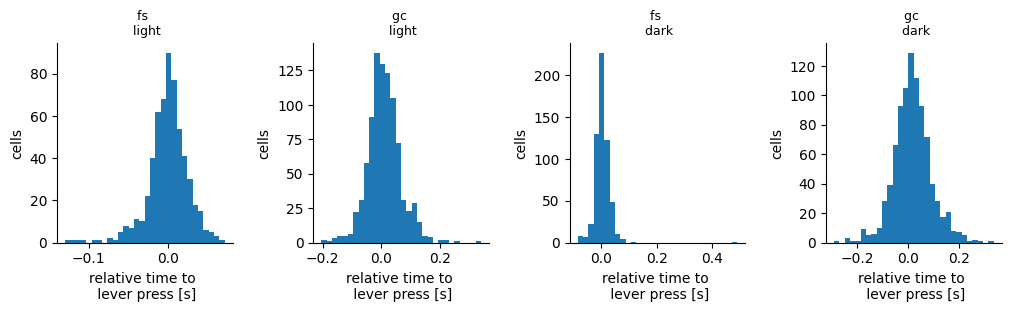

In [114]:
col=4
row=2
sizePerRow, sizePerCol = 2.5,2.5
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(row,col, figure=fig, wspace= 0.1) # all our figure

ax= fig.add_subplot(gs[0])
light= 'light'
ax.hist(df_fs[(df_fs.light==light)].expval, bins=30)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("relative time to \n lever press [s]")
ax.set_ylabel("cells")
ax.set_title(f'fs \n {light}', fontsize= 9)

ax= fig.add_subplot(gs[1])
ax.hist(df_gc[(df_gc.light==light)].expval, bins=30)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("relative time to \n lever press [s]")
ax.set_ylabel("cells")
ax.set_title(f'gc \n {light}', fontsize= 9)


ax= fig.add_subplot(gs[2])
light= 'dark'
ax.hist(df_fs[(df_fs.light==light)].expval, bins=30)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("relative time to \n lever press [s]")
ax.set_ylabel("cells")
ax.set_title(f'fs \n {light}', fontsize= 9)

ax= fig.add_subplot(gs[3])
ax.hist(df_gc[(df_gc.light==light)].expval, bins=30)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("relative time to \n lever press [s]")
ax.set_ylabel("cells")
ax.set_title(f'gc \n {light}', fontsize= 9)

In [116]:
fsclu_light= df_fs[(df_fs.light=='light')&(df_fs.expval<0.01) & (df_fs.expval>-0.01)]
fsclu_dark= df_fs[(df_fs.light=='dark')&(df_fs.expval<0.01) & (df_fs.expval>-0.01)]

save the df so I dont need to run this again 

'/adata/projects/autopi_inter/result/fsgc_expvalues.csv'

In [119]:
fn= myProject.dataPath+ 'result/fsgc_expvalues.csv'
fn= 'fsgc_expvalues.csv'
expValdf.to_csv(fn , index=False)